In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import cv2
import os
import numpy as np

MAX_NB_CLASSES = 5


def extract_images(video_input_file_path, image_output_dir_path):
    if os.path.exists(image_output_dir_path):
        return
    count = 0
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            cv2.imwrite(image_output_dir_path + os.path.sep + "frame%d.jpg" % count, image)  # save frame as JPEG file
            count = count + 1


def extract_features(video_input_file_path, feature_output_file_path):
    if os.path.exists(feature_output_file_path):
        return np.load(feature_output_file_path)
    count = 0
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    features = []
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            img = cv2.resize(image, (40,40), interpolation=cv2.INTER_AREA)
            features.append(image)
            count = count + 1
    unscaled_features = np.array(features)
    print(unscaled_features.shape)
    np.save(feature_output_file_path, unscaled_features)
    return unscaled_features


def extract_videos_for_conv2d(video_input_file_path, feature_output_file_path, max_frames):
    if feature_output_file_path is not None:
        if os.path.exists(feature_output_file_path):
            return np.load(feature_output_file_path)
    count = 0
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    features = []
    success = True
    while success and count < max_frames:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            channels = image.shape[2]
            for channel in range(channels):
                features.append(image[:, :, channel])
            count = count + 1
    unscaled_features = np.array(features)
    unscaled_features = np.transpose(unscaled_features, axes=(1, 2, 0))
    print(unscaled_features.shape)
    if feature_output_file_path is not None:
        np.save(feature_output_file_path, unscaled_features)
    return unscaled_features


def scan_and_extract_images(data_dir_path):
    input_data_dir_path = data_dir_path + '/vietnamese_1'
    output_frame_data_dir_path = data_dir_path + '/WLASL-Frames'

    if not os.path.exists(output_frame_data_dir_path):
        os.makedirs(output_frame_data_dir_path)

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        if not os.path.isfile(file_path):
            output_dir_name = f
            output_dir_path = output_frame_data_dir_path + os.path.sep + output_dir_name
            if not os.path.exists(output_dir_path):
                os.makedirs(output_dir_path)
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                output_image_folder_path = output_dir_path + os.path.sep + ff.split('.')[0]
                if not os.path.exists(output_image_folder_path):
                    os.makedirs(output_image_folder_path)
                extract_images(video_file_path, output_image_folder_path)
        if dir_count == MAX_NB_CLASSES:
            break


def scan_and_extract_features(data_dir_path, data_set_name=None):
    if data_set_name is None:
        data_set_name = 'vietnamese_1'
    input_data_dir_path = data_dir_path + '/' + data_set_name
    output_feature_data_dir_path = data_dir_path + '/' + data_set_name + '-Features'

    if not os.path.exists(output_feature_data_dir_path):
        os.makedirs(output_feature_data_dir_path)

    y_samples = []
    x_samples = []

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        if not os.path.isfile(file_path):
            output_dir_name = f
            output_dir_path = output_feature_data_dir_path + os.path.sep + output_dir_name
            if not os.path.exists(output_dir_path):
                os.makedirs(output_dir_path)
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                output_feature_file_path = output_dir_path + os.path.sep + ff.split('.')[0] + '.npy'
                x = extract_features(video_file_path, output_feature_file_path)
                y = f
                y_samples.append(y)
                x_samples.append(x)

        if dir_count == MAX_NB_CLASSES:
            break

    return x_samples, y_samples


def scan_and_extract_videos_for_conv2d(data_dir_path, data_set_name=None, max_frames=None):
    if data_set_name is None:
        data_set_name = 'vietnamese_1'
    if max_frames is None:
        max_frames = 10

    input_data_dir_path = data_dir_path + '/' + data_set_name
    output_feature_data_dir_path = data_dir_path + '/' + data_set_name + '-Conv2d'

    if not os.path.exists(output_feature_data_dir_path):
        os.makedirs(output_feature_data_dir_path)

    y_samples = []
    x_samples = []

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        if not os.path.isfile(file_path):
            output_dir_name = f
            output_dir_path = output_feature_data_dir_path + os.path.sep + output_dir_name
            if not os.path.exists(output_dir_path):
                os.makedirs(output_dir_path)
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                output_feature_file_path = output_dir_path + os.path.sep + ff.split('.')[0] + '.npy'
                x = extract_videos_for_conv2d(video_file_path, output_feature_file_path, max_frames)
                y = f
                y_samples.append(y)
                x_samples.append(x)

        if dir_count == MAX_NB_CLASSES:
            break

    return x_samples, y_samples


#def main():
#    print(cv2.__version__)
#    data_dir_path = '/content/drive/MyDrive/PBL6/vocab_dataset/WLASL_ar'
#    X, Y = scan_and_extract_videos_for_conv2d(data_dir_path)
#    print(X[0].shape)


#if __name__ == '__main__':
#    main()

In [40]:
import cv2
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD

MAX_NB_CLASSES = 10


def extract_vgg16_features_live(model, video_input_file_path):
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    features = []
    success = True
    count = 0
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            input = img_to_array(img)
            input = np.expand_dims(input, axis=0)
            input = preprocess_input(input)
            feature = model.predict(input).ravel()
            features.append(feature)
            count = count + 1
    unscaled_features = np.array(features)
    return unscaled_features


def extract_vgg16_features(model, video_input_file_path, feature_output_file_path):
    if os.path.exists(feature_output_file_path):
        return np.load(feature_output_file_path)
    count = 0
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    features = []
    success = True
    while success :
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 100))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            input = img_to_array(img)
            input = np.expand_dims(input, axis=0)
            input = preprocess_input(input)
            feature = model.predict(input).ravel()
            features.append(feature)
            count = count + 1

    unscaled_features = np.array(features)
    np.save(feature_output_file_path, unscaled_features)
    return unscaled_features


def scan_and_extract_vgg16_features(data_dir_path, output_dir_path, model=None, data_set_name=None):
    if data_set_name is None:
        data_set_name = 'vietnamese_1'

    input_data_dir_path = data_dir_path + '/' + data_set_name
    output_feature_data_dir_path = data_dir_path + '/' + output_dir_path

    if model is None:
        model = VGG16(include_top=True, weights='imagenet')
        model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

    if not os.path.exists(output_feature_data_dir_path):
        os.makedirs(output_feature_data_dir_path)

    y_samples = []
    x_samples = []

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        if not os.path.isfile(file_path):
            output_dir_name = f
            output_dir_path = output_feature_data_dir_path + os.path.sep + output_dir_name
            if not os.path.exists(output_dir_path):
                os.makedirs(output_dir_path)
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                output_feature_file_path = output_dir_path + os.path.sep + ff.split('.')[0] + '.npy'
                x = extract_vgg16_features(model, video_file_path, output_feature_file_path)
                y = f
                y_samples.append(y)
                x_samples.append(x)

        if dir_count == MAX_NB_CLASSES:
            break

    return x_samples, y_samples

In [41]:
from matplotlib import pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def create_history_plot(history, model_name, metrics=None):
    plt.figure(figsize = (20,10))
    plt.title('Accuracy and Loss (' + model_name + ')')
    if metrics is None:
        metrics = {'accucary', 'loss'}
    if 'accuracy' in metrics:
        plt.subplot(1,2,1)
        plt.title('Accuracy')
        plt.plot(history.history['accuracy'], color='g', label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
        plt.legend(loc='best')
    if 'loss' in metrics:
        plt.subplot(1,2,2)
        plt.title('Loss')
        plt.plot(history.history['loss'], color='r', label='Train Loss')
        plt.plot(history.history['val_loss'], color='m', label='Validation Loss')
        plt.legend(loc='best')

    plt.tight_layout()


def plot_history(history, model_name):
    create_history_plot(history, model_name)
    plt.show()


def plot_and_save_history(history, model_name, file_path, metrics=None):
    if metrics is None:
        metrics = {'accuracy', 'loss'}
    create_history_plot(history, model_name, metrics)
    plt.savefig(file_path)

In [42]:
from keras.layers import Dense, Activation, Dropout, Bidirectional
from keras.layers import LSTM
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

In [52]:
BATCH_SIZE = 4
NUM_EPOCHS = 50
VERBOSE = 1
HIDDEN_UNITS = 64
MAX_ALLOWED_FRAMES = 15
EMBEDDING_SIZE = 50


def generate_batch(x_samples, y_samples):
    num_batches = len(x_samples) // BATCH_SIZE

    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            yield np.array(x_samples[start:end]), y_samples[start:end]

class VGG16LSTMVideoClassifier(object):
    model_name = 'vgg16-lstm'

    def __init__(self):
        self.num_input_tokens = None
        self.nb_classes = None
        self.labels = None
        self.labels_idx2word = None
        self.model = None
        self.vgg16_model = None
        self.expected_frames = None
        self.vgg16_include_top = None
        self.config = None

    @staticmethod
    def get_config_file_path(model_dir_path, vgg16_include_top=None,allow_pickle=True):
        if vgg16_include_top is None:
            vgg16_include_top = True
        if vgg16_include_top:
            return model_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-config.npy'
        else:
            return model_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-hi-dim-config.npy'

    @staticmethod
    def get_weight_file_path(model_dir_path, vgg16_include_top=None,allow_pickle=True):
        if vgg16_include_top is None:
            vgg16_include_top = True
        if vgg16_include_top:
            return model_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-weights.h5'
        else:
            return model_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-hi-dim-weights.h5'

    @staticmethod
    def get_architecture_file_path(model_dir_path, vgg16_include_top=None):
        if vgg16_include_top is None:
            vgg16_include_top = True
        if vgg16_include_top:
            return model_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-architecture.json'
        else:
            return model_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-hi-dim-architecture.json'

    def create_model(self):
        model = Sequential()

        model.add(
            LSTM(units=HIDDEN_UNITS, input_shape=(None, self.num_input_tokens), return_sequences=False, dropout=0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.nb_classes))
        model.add(Activation('softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        return model

    def load_model(self, config_file_path, weight_file_path, allow_pickle=True):

        config = np.load(config_file_path, allow_pickle=True).item()
        self.num_input_tokens = config['num_input_tokens']
        self.nb_classes = config['nb_classes']
        self.labels = config['labels']
        self.expected_frames = config['expected_frames']
        self.vgg16_include_top = config['vgg16_include_top']
        self.labels_idx2word = dict([(idx, word) for word, idx in self.labels.items()])

        self.model = self.create_model()
        self.model.load_weights(weight_file_path)

        vgg16_model = VGG16(include_top=self.vgg16_include_top, weights='imagenet')
        vgg16_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        self.vgg16_model = vgg16_model

    def predict(self, video_file_path):
        x = extract_vgg16_features_live(self.vgg16_model, video_file_path)
        frames = x.shape[0]
        if frames > self.expected_frames:
            x = x[0:self.expected_frames, :]
        elif frames < self.expected_frames:
            temp = np.zeros(shape=(self.expected_frames, x.shape[1]))
            temp[0:frames, :] = x
            x = temp
        predicted_class = np.argmax(self.model.predict(np.array([x]))[0])
        predicted_label = self.labels_idx2word[predicted_class]
        return predicted_label

    def fit(self, data_dir_path, model_dir_path, vgg16_include_top=True, data_set_name='vietnamese_ar', test_size=0.2, random_state=42):
        self.vgg16_include_top = vgg16_include_top

        config_file_path = self.get_config_file_path(model_dir_path, vgg16_include_top)
        weight_file_path = self.get_weight_file_path(model_dir_path, vgg16_include_top)
        architecture_file_path = self.get_architecture_file_path(model_dir_path, vgg16_include_top)

        vgg16_model = VGG16(include_top=self.vgg16_include_top, weights='imagenet')
        vgg16_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        self.vgg16_model = vgg16_model

        feature_dir_name = data_set_name + '-VGG16-Features'
        if not vgg16_include_top:
            feature_dir_name = data_set_name + '-VGG16-HiDimFeatures'
        max_frames = 0
        self.labels = dict()
        x_samples, y_samples = scan_and_extract_vgg16_features(data_dir_path,
                                                               output_dir_path=feature_dir_name,
                                                               model=self.vgg16_model,
                                                               data_set_name=data_set_name)
        self.num_input_tokens = x_samples[0].shape[1]
        frames_list = []
        for x in x_samples:
            frames = x.shape[0]
            frames_list.append(frames)
            max_frames = max(frames, max_frames)
            self.expected_frames = int(np.mean(frames_list))
        print('max frames: ', max_frames)
        print('expected frames: ', self.expected_frames)
        for i in range(len(x_samples)):
            x = x_samples[i]
            frames = x.shape[0]
            print(x.shape)
            if frames > self.expected_frames:
                x = x[0:self.expected_frames, :]
                x_samples[i] = x
            elif frames < self.expected_frames:

                temp = np.zeros(shape=(self.expected_frames, x.shape[1]))
                temp[0:frames, :] = x
                x_samples[i] = temp
        for y in y_samples:
            if y not in self.labels:
                self.labels[y] = len(self.labels)
        print(self.labels)
        for i in range(len(y_samples)):
            y_samples[i] = self.labels[y_samples[i]]

        self.nb_classes = len(self.labels)

        y_samples = to_categorical(y_samples, self.nb_classes)

        config = dict()
        config['labels'] = self.labels
        config['nb_classes'] = self.nb_classes
        config['num_input_tokens'] = self.num_input_tokens
        config['expected_frames'] = self.expected_frames
        config['vgg16_include_top'] = self.vgg16_include_top
        self.config = config

        np.save(config_file_path, config)

        model = self.create_model()
        open(architecture_file_path, 'w').write(model.to_json())

        Xtrain, Xtest, Ytrain, Ytest = train_test_split(x_samples, y_samples, test_size=test_size,
                                                        random_state=random_state)

        train_gen = generate_batch(Xtrain, Ytrain)
        test_gen = generate_batch(Xtest, Ytest)

        train_num_batches = len(Xtrain) // BATCH_SIZE
        test_num_batches = len(Xtest) // BATCH_SIZE


        checkpoint = ModelCheckpoint(filepath=weight_file_path, save_best_only=True)
        history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                      epochs=NUM_EPOCHS,
                                      verbose=1, validation_data=test_gen, validation_steps=test_num_batches,
                                      callbacks=[checkpoint])
        model.save_weights(weight_file_path)

        return history

In [53]:
import numpy as np
from keras import backend as K
import sys
import os

data_set_name = 'vietnamese_1'
input_dir_path = '/content/drive/MyDrive/PBL6_vietnamese'
output_dir_path = os.path.join('/content/drive/MyDrive/PBL6_vietnamese', 'models', data_set_name)
report_dir_path = os.path.join('/content/drive/MyDrive/PBL6_vietnamese', 'reports', data_set_name)

np.random.seed(32)

    # this line downloads the video files of UCF-101 dataset if they are not available in the very_large_data folder

classifier = VGG16LSTMVideoClassifier()

history = classifier.fit(data_dir_path=input_dir_path, model_dir_path=output_dir_path, data_set_name=data_set_name)





max frames:  31
expected frames:  17
(19, 1000)
(18, 1000)
(22, 1000)
(22, 1000)
(18, 1000)
(18, 1000)
(20, 1000)
(25, 1000)
(23, 1000)
(18, 1000)
(21, 1000)
(20, 1000)
(23, 1000)
(21, 1000)
(22, 1000)
(15, 1000)
(20, 1000)
(22, 1000)
(17, 1000)
(20, 1000)
(18, 1000)
(19, 1000)
(23, 1000)
(20, 1000)
(17, 1000)
(23, 1000)
(22, 1000)
(18, 1000)
(20, 1000)
(21, 1000)
(19, 1000)
(18, 1000)
(19, 1000)
(19, 1000)
(24, 1000)
(20, 1000)
(24, 1000)
(19, 1000)
(19, 1000)
(22, 1000)
(20, 1000)
(18, 1000)
(21, 1000)
(18, 1000)
(21, 1000)
(18, 1000)
(18, 1000)
(16, 1000)
(19, 1000)
(21, 1000)
(20, 1000)
(23, 1000)
(18, 1000)
(20, 1000)
(21, 1000)
(17, 1000)
(24, 1000)
(20, 1000)
(19, 1000)
(20, 1000)
(19, 1000)
(17, 1000)
(17, 1000)
(19, 1000)
(18, 1000)
(17, 1000)
(16, 1000)
(16, 1000)
(16, 1000)
(16, 1000)
(18, 1000)
(16, 1000)
(16, 1000)
(18, 1000)
(16, 1000)
(19, 1000)
(16, 1000)
(20, 1000)
(16, 1000)
(16, 1000)
(16, 1000)
(14, 1000)
(16, 1000)
(18, 1000)
(16, 1000)
(17, 1000)
(15, 1000)
(15, 1

IndexError: ignored

<ipython-input-5-5dfa25f92fc3>:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


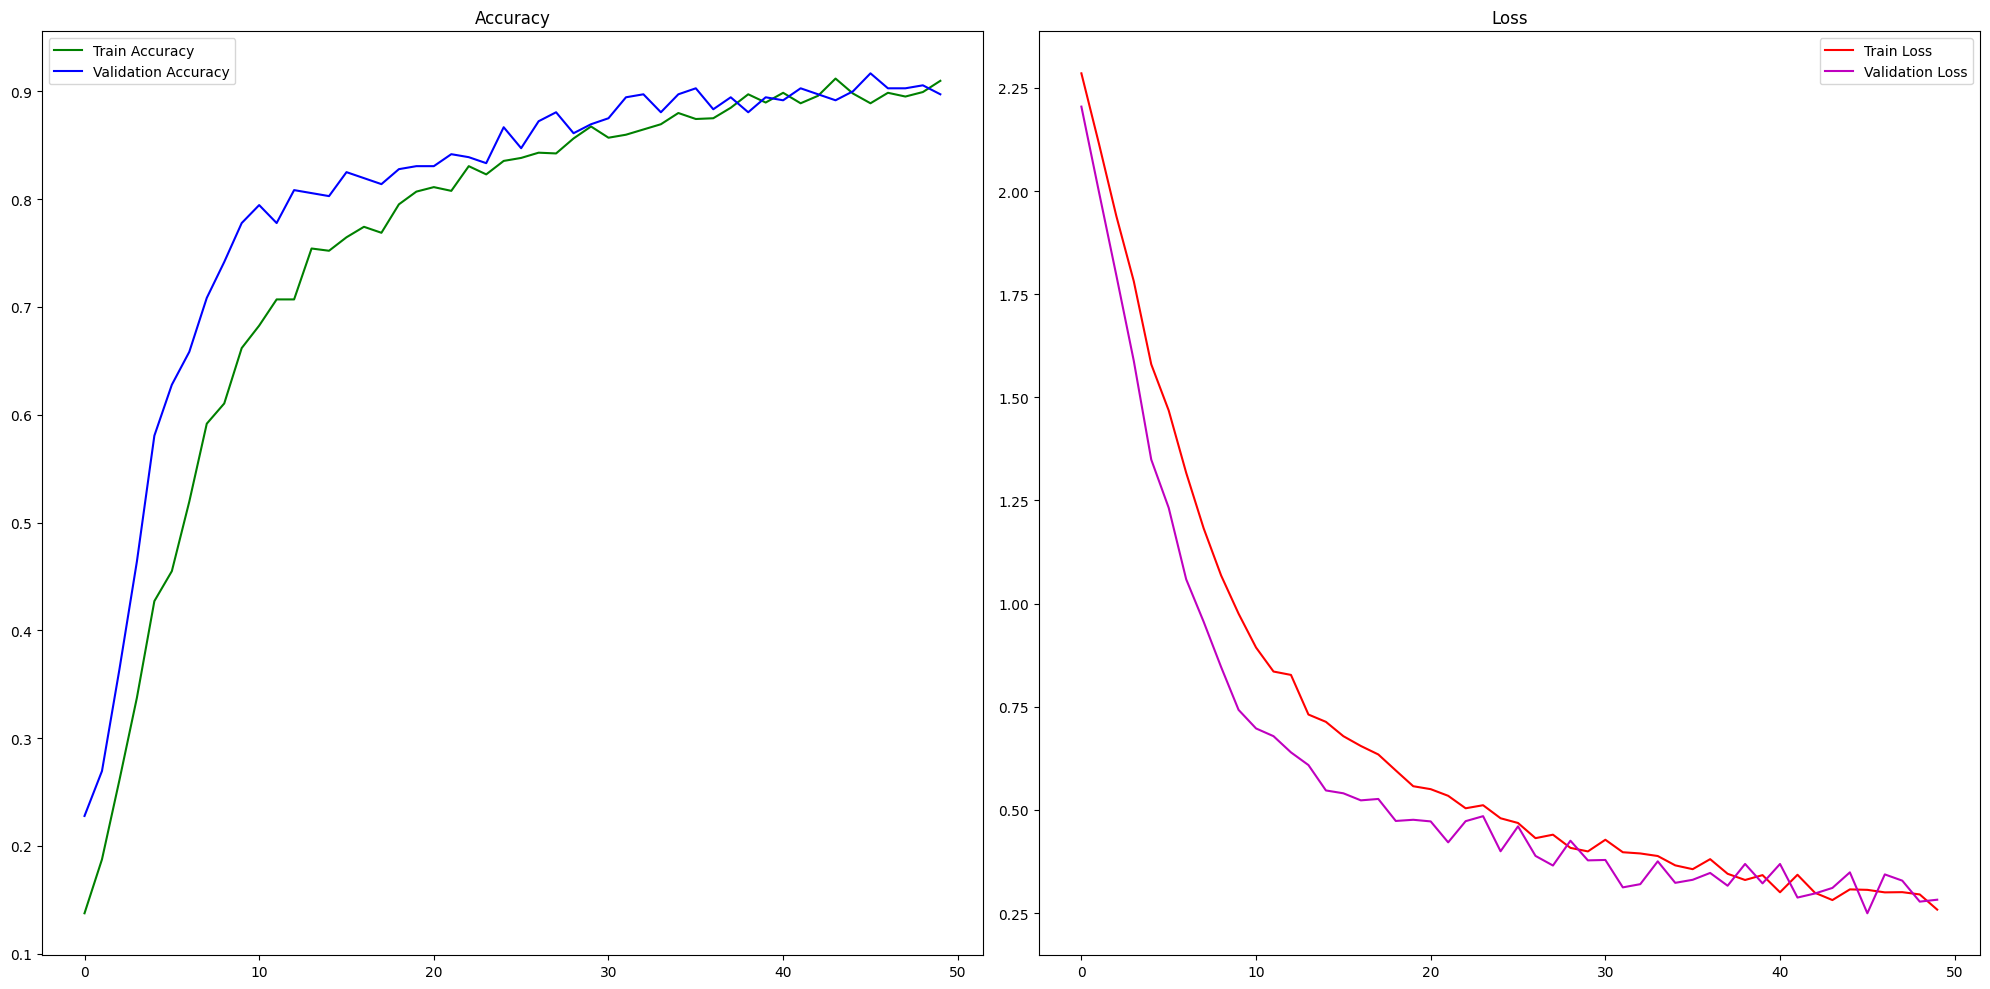

In [30]:
plot_and_save_history(history, VGG16LSTMVideoClassifier.model_name,
                          report_dir_path + '/' + VGG16LSTMVideoClassifier.model_name + '-history.png')


In [10]:
def scan_data(data_dir_path, limit):
    input_data_dir_path = data_dir_path + '/vietnamese_1'

    result = dict()

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        if not os.path.isfile(file_path):
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                result[video_file_path] = f
        if dir_count == limit:
            break
    return result


def scan_data_with_labels(data_dir_path, labels):
    input_data_dir_path = data_dir_path + '/vietnamese_1'

    result = dict()

    dir_count = 0
    for label in labels:
        file_path = input_data_dir_path + os.path.sep + label
        if not os.path.isfile(file_path):
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                result[video_file_path] = label
    return result

In [37]:
import numpy as np

#from keras_video_classifier.library.recurrent_networks import VGG16BidirectionalLSTMVideoClassifier
#from keras_video_classifier.library.utility.ucf.UCF101_loader import load_ucf, scan_ucf_with_labels

vgg16_include_top = True
data_set_name = 'vietnamese_ar'
data_dir_path = '/content/drive/MyDrive/PBL6_vietnamese'
model_dir_path = '/content/drive/MyDrive/PBL6_vietnamese/models/' + data_set_name
config_file_path = VGG16LSTMVideoClassifier.get_config_file_path(model_dir_path,
                                                                              vgg16_include_top=vgg16_include_top)
weight_file_path =VGG16LSTMVideoClassifier.get_weight_file_path(model_dir_path,
                                                                              vgg16_include_top=vgg16_include_top)

np.random.seed(42)

# this line downloads the video files of UCF-101 dataset if they are not available in the very_large_data folder
#load_ucf(data_dir_path)

predictor = VGG16LSTMVideoClassifier()
predictor.load_model(config_file_path, weight_file_path)

# scan_ucf returns a dictionary object of (video_file_path, video_class_label) where video_file_path
# is the key and video_class_label is the value
#videos = scan_data_with_labels(data_dir_path, [label for (label, label_index) in predictor.labels.items()])

video_file_path = '/content/drive/MyDrive/PBL6_vietnamese/vietnamese_1/nhinthay/WIN_20240103_19_58_52_Pro.mp4'

correct_count = 0
count = 0



predicted_label = predictor.predict(video_file_path)
print('predicted: ' + predicted_label )

Extracting frames from video:  /content/drive/MyDrive/PBL6_vietnamese/vietnamese_1/nhinthay/WIN_20240103_19_58_52_Pro.mp4
1/1 [==============================] - 0s 495ms/step
predicted: dangkia
